In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import my_utils as mu
#!pip install phyaat  # if not installed yet
import phyaat as ph

PhyAAt Processing lib Loaded...


In [2]:
baseDir='PhyAAt_Data'   # or dirPath return path from above
dirPath = ph.download_data(baseDir=baseDir, subject=-1,verbose=0,overwrite=False)

# baseDir='code/PhyAAt_Data' 
#returns a dictionary containing file names of all the subjects available in baseDir
SubID = ph.ReadFilesPath(baseDir)

#check files of subject=1
print(SubID[1])

Total Subjects :  25
{'sigFile': 'PhyAAt_Data/phyaat_dataset/Signals/S1/.ipynb_checkpoints/S1_Signals-checkpoint.csv', 'txtFile': 'PhyAAt_Data/phyaat_dataset/Signals/S1/.ipynb_checkpoints/S1_Textscore-checkpoint.csv'}


In [3]:
SubID.keys()

dict_keys([5, 2, 3, 4, 19, 21, 17, 10, 11, 16, 20, 18, 8, 1, 6, 7, 9, 22, 25, 13, 14, 15, 12, 24, 23])

In [4]:
ls = ['S{}'.format(i) for i in range(1,26)]
col = ['Task{}'.format(i) for i in range(1,4)]
result = pd.DataFrame(index = ls, columns = col)

## Within-subject Experiment

In [5]:
for i in sorted(SubID.keys()):
    print ('Now Loading Subject:', i)
    Subj = ph.Subject(SubID[i])

    # Use preprocessed EEG
    eeg_clean = pd.read_csv('eeg_clean/{}.csv'.format(i))
    Subj.filter_EEG(band =[0.5],btype='highpass',order=5)
    Subj.updateEEG(eeg_clean)  

    for task_No in range(1,4):
        
        X_train,y_train,X_test, y_test = Subj.getXy_eeg(task= task_No, redo = True, winsize = 128 * 3)
        
        # Normalization - SVM works well with normalized features
        means = X_train.mean(0)
        std   = X_train.std(0)
        X_train = (X_train-means)/std
        X_test  = (X_test-means)/std

        # Training
        clf = svm.SVC(kernel='rbf', C=1,gamma='auto')
        clf.fit(X_train,y_train)

        # Predition
        ytp = clf.predict(X_train)
        ysp = clf.predict(X_test)

        # Evaluation
        train_acc = round(np.mean(y_train==ytp),2)
        test_acc = round(np.mean(y_test==ysp),2)
        
        result.at["S{}".format(i), "Task{}".format(task_No)] = test_acc
        
        print('Training Accuracy:',train_acc)
        print('Testing  Accuracy:',test_acc)
        


Now Loading Subject: 1
100%|##################################################|100\100|Sg - 0
Done..
100%|##################################################|43\43|Sg - 0
Done..
Training Accuracy: 0.61
Testing  Accuracy: 0.31
100%|##################################################|100\100|Sg - 0
Done..
100%|##################################################|43\43|Sg - 0
Done..
Training Accuracy: 0.85
Testing  Accuracy: 0.16
100%|##################################################|100\100|Sg - 0
Done..
100%|##################################################|43\43|Sg - 0
Done..
Training Accuracy: 0.84
Testing  Accuracy: 0.62
Now Loading Subject: 2
100%|##################################################|100\100|Sg - 0
Done..
100%|##################################################|43\43|Sg - 0
Done..
Training Accuracy: 0.64
Testing  Accuracy: 0.06
100%|##################################################|100\100|Sg - 0
Done..
100%|##################################################|43\43|Sg - 0

In [6]:
result.at['Avg_Acc'] = round(result.mean(axis = 0, skipna = True),2)
chance_acc = [0.1, 0.17, 0.5]
result.at['Chance_Acc'] = chance_acc
result = result.drop(index = 'S24')
result.to_csv('result_SVM.csv')
result.plot.bar(subplots = True, figsize = (20, 6), ylabel = 'Accuracy', rot = 45)

In [8]:
# map task 1 score (0-100) into 10 groups

def new_c_level(row):
    level = row.iloc[0] // 10
    if level == 10:
        return str(int(level - 1))
    else:
        return str(int(level))

In [9]:
for task_No in range(1,4):
    print("all-subject task:", task_No)
    
    X_train = pd.read_csv('extracted_data/T{}_3s_X_train.csv'.format(task_No))
    y_train = pd.read_csv('extracted_data/T{}_3s_y_train.csv'.format(task_No))
    X_test = pd.read_csv('extracted_data/T{}_3s_X_test.csv'.format(task_No))
    y_test = pd.read_csv('extracted_data/T{}_3s_y_test.csv'.format(task_No))
    

    # Normalization - SVM works well with normalized features
    means = X_train.mean(0)
    std   = X_train.std(0)
    X_train = (X_train-means)/std
    X_test  = (X_test-means)/std
    
    if task_No == 1:
        y_train.iloc[:,0] = y_train.apply(new_c_level, axis=1)
        y_test.iloc[:,0] = y_test.apply(new_c_level, axis=1)

    y_train = y_train.to_numpy().reshape(-1)
    y_test = y_test.to_numpy().reshape(-1)
    

    # Training
    clf = svm.SVC(kernel='rbf', C=1,gamma='auto')
    clf.fit(X_train,y_train)
    
    # Predition
    ytp = clf.predict(X_train)
    ysp = clf.predict(X_test)

    # Evaluation
    train_acc = round(np.mean(y_train==ytp),2)
    test_acc = round(np.mean(y_test==ysp),2)

    result.at["All_subject", "Task{}".format(task_No)] = test_acc

    print('Training Accuracy:',train_acc)
    print('Testing  Accuracy:',test_acc)

all-subject task: 1
Training Accuracy: 0.43
Testing  Accuracy: 0.33
all-subject task: 2
Training Accuracy: 0.49
Testing  Accuracy: 0.15
all-subject task: 3
Training Accuracy: 0.67
Testing  Accuracy: 0.58
PhyAAt Processing lib Loaded...
PhyAAt Processing lib Loaded...
PhyAAt Processing lib Loaded...
PhyAAt Processing lib Loaded...


array([<AxesSubplot:title={'center':'Task1'}, ylabel='Accuracy'>,
       <AxesSubplot:title={'center':'Task2'}, ylabel='Accuracy'>,
       <AxesSubplot:title={'center':'Task3'}, ylabel='Accuracy'>],
      dtype=object)

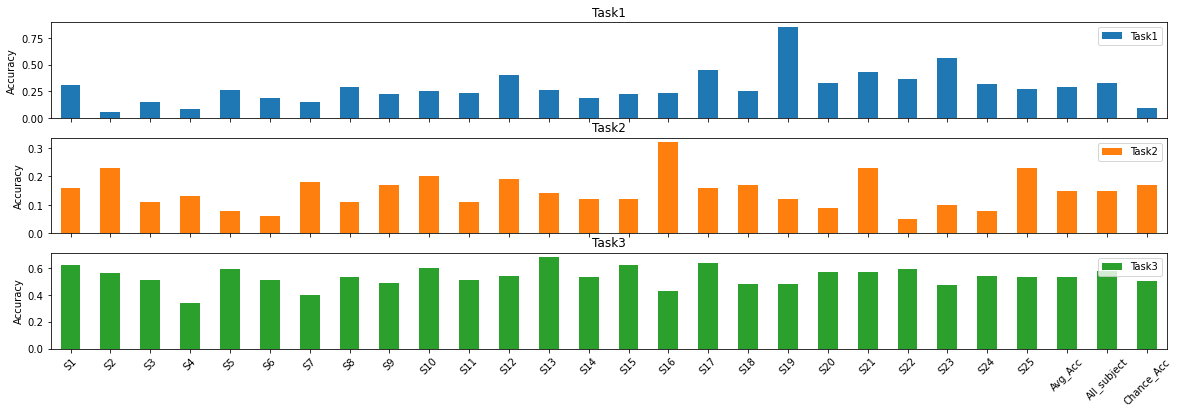

In [10]:
chance_acc = [0.1, 0.17, 0.5]
result.at['Chance_Acc'] = chance_acc
result.to_csv('result_SVM.csv')
result.plot.bar(subplots = True, figsize = (20, 6), ylabel = 'Accuracy', rot = 45)

array([<AxesSubplot:title={'center':'Task1'}, ylabel='Accuracy'>,
       <AxesSubplot:title={'center':'Task2'}, ylabel='Accuracy'>,
       <AxesSubplot:title={'center':'Task3'}, ylabel='Accuracy'>],
      dtype=object)

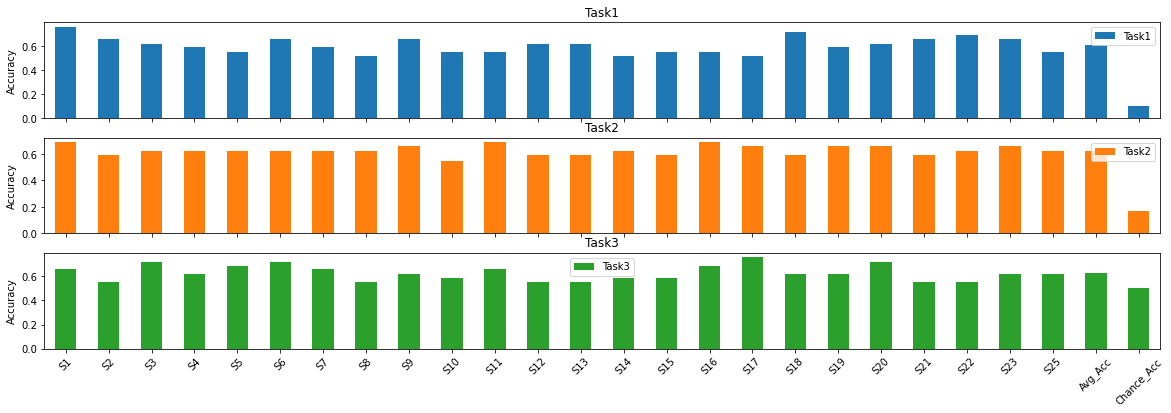

In [19]:
import pandas as pd
result = pd.read_csv('result_cnn_S24.csv',index_col = 0)
result = result.drop(index = 'All_Subject')
result.plot.bar(subplots = True, figsize = (20, 6), ylabel = 'Accuracy', rot = 45)